In [359]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import copy

### Build basis and Hamiltonian

In [369]:
Nsites = 6
Nbosons = 6
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [370]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis


def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'


def isodd(n):
    return int(n) % 2 == True


def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)


def gaugeFixedBasis(Nsites, Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons + 1) ** Nsites):
        bosonString = np.base_repr(number, base=Nbosons + 1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state) - 1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0:  # For the first site
                thislink = '-' * (isodd(thisn)) + '+' * (not isodd(thisn))
            else:  # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)

    print(gaugefixedStates)
    return gaugefixedStates


# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c, Nbosons):
    # print("site state ", basis(Nbosons + 1, int(c)))
    return basis(Nbosons + 1, np.abs(Nbosons-int(c)))


def linkState(c):
    if c == '+':
        # print("link state ", (basis(2, 0) + basis(2, 1)).unit())
        return (basis(2, 0) + basis(2, 1)).unit()
    elif c == '-':
        return (basis(2, 0) - basis(2, 1)).unit()


basisStatesList = gaugeFixedBasis(Nsites, Nbosons)
#print(basisStatesList)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList:  # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        # print("c ",c)
        if isodd(ind):
            basisVector.append(linkState(c))
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        if ind % 2 == 0:
            basisVector.append(siteState(c, Nbosons))

    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis), i) * fullBasis[i].dag()

P_sparse = P_gaugefixed.data

['0+0+0+0+0+6', '0+0+0+0+1-5', '0+0+0+0+2+4', '0+0+0+0+3-3', '0+0+0+0+4+2', '0+0+0+0+5-1', '0+0+0+0+6+0', '0+0+0+1-0-5', '0+0+0+1-1+4', '0+0+0+1-2-3', '0+0+0+1-3+2', '0+0+0+1-4-1', '0+0+0+1-5+0', '0+0+0+2+0+4', '0+0+0+2+1-3', '0+0+0+2+2+2', '0+0+0+2+3-1', '0+0+0+2+4+0', '0+0+0+3-0-3', '0+0+0+3-1+2', '0+0+0+3-2-1', '0+0+0+3-3+0', '0+0+0+4+0+2', '0+0+0+4+1-1', '0+0+0+4+2+0', '0+0+0+5-0-1', '0+0+0+5-1+0', '0+0+0+6+0+0', '0+0+1-0-0-5', '0+0+1-0-1+4', '0+0+1-0-2-3', '0+0+1-0-3+2', '0+0+1-0-4-1', '0+0+1-0-5+0', '0+0+1-1+0+4', '0+0+1-1+1-3', '0+0+1-1+2+2', '0+0+1-1+3-1', '0+0+1-1+4+0', '0+0+1-2-0-3', '0+0+1-2-1+2', '0+0+1-2-2-1', '0+0+1-2-3+0', '0+0+1-3+0+2', '0+0+1-3+1-1', '0+0+1-3+2+0', '0+0+1-4-0-1', '0+0+1-4-1+0', '0+0+1-5+0+0', '0+0+2+0+0+4', '0+0+2+0+1-3', '0+0+2+0+2+2', '0+0+2+0+3-1', '0+0+2+0+4+0', '0+0+2+1-0-3', '0+0+2+1-1+2', '0+0+2+1-2-1', '0+0+2+1-3+0', '0+0+2+2+0+2', '0+0+2+2+1-1', '0+0+2+2+2+0', '0+0+2+3-0-1', '0+0+2+3-1+0', '0+0+2+4+0+0', '0+0+3-0-0-3', '0+0+3-0-1+2', '0+0+3-0-

In [371]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
print(basis_boson)
basis = tensor_basis(basis_spin, basis_boson)
print(basis.index("10","010"))

reference states: 
array index   /   Fock state   /   integer repr. 
          0.         |6 6 6 6 6 6>           117648  
          1.         |6 6 6 6 6 5>           117647  
          2.         |6 6 6 6 6 4>           117646  
          3.         |6 6 6 6 6 3>           117645  
          4.         |6 6 6 6 6 2>           117644  
          5.         |6 6 6 6 6 1>           117643  
          6.         |6 6 6 6 6 0>           117642  
          7.         |6 6 6 6 5 6>           117641  
          8.         |6 6 6 6 5 5>           117640  
          9.         |6 6 6 6 5 4>           117639  
         10.         |6 6 6 6 5 3>           117638  
         11.         |6 6 6 6 5 2>           117637  
         12.         |6 6 6 6 5 1>           117636  
         13.         |6 6 6 6 5 0>           117635  
         14.         |6 6 6 6 4 6>           117634  
         15.         |6 6 6 6 4 5>           117633  
         16.         |6 6 6 6 4 4>           117632  
         17. 

### Build Hamiltonian and calculate ground state

#### Hopping dominates: ground state is (1/2 |2+0> + 1/2 |0+2> + 1/sqrt(2) |1-1>)

In [410]:
hop = [[-10, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[0, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))
for i in range(len(psi0)):
    print(np.abs(psi0[i]))

[-6.30606678e-14] [-3.99680289e-14] [-2.30926389e-14]
[0.00015561] [0.00068683] [0.00195687]
[0.00015561]
[0.00068683]
[0.00195687]
[0.00407165]
[0.00635391]
[0.0072412]
[0.0053269]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.01536308]
[0.03915011]
[0.0498836]
[0.0218327]
[0.03934116]
[0.02002769]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00430323]
[0.01550832]
[0.03422553]
[0.0503552]
[0.04536847]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.03072616]
[0.07830023]
[0.09976721]
[0.04881939]
[0.08796951]
[0.04905762]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.0376317]
[0.0958978]
[0.12218938]
[0.06904105]
[0.12440767]
[0.07756692]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.03072616]
[0.07830023]
[0.09976

In [411]:
print(abs(psi0.T.conj()@psi0)**2)

[[1.]]


In [412]:
psi0_notgaugefixed = P_sparse.T @ psi0
np.allclose(P_sparse.T.conj() @ psi0, P_sparse.T @ psi0)

True

In [413]:
for i in range(Nbosons):
    obs_args={"basis":basis,"check_herm":False,"check_symm":False}
    n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)
    Obs_t = obs_vs_time(psi0_notgaugefixed,t,{"n":n})
    O_n = Obs_t["n"]
    print(i, " ", np.real(O_n))

/tmp/ipykernel_24753/3842016218.py:3: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)


0   [0.32272303]
1   [1.04787509]
2   [1.62940189]
3   [1.62940189]
4   [1.04787509]
5   [0.32272303]


0   [[0.32272303]]
1   [[1.04787509]]
2   [[1.62940189]]
3   [[1.62940189]]
4   [[1.04787509]]
5   [[0.32272303]]
[[ 0.64544605  2.09575017  3.25880377  3.25880377  2.09575017  0.64544605]
 [ 1.1630536   2.61335772  3.25880377  2.61335772  1.1630536  -1.        ]
 [ 1.45030412  2.61335772  2.61335772  1.45030412 -1.         -1.        ]
 [ 1.45030412  2.09575017  1.45030412 -1.         -1.         -1.        ]
 [ 1.1630536   1.1630536  -1.         -1.         -1.         -1.        ]
 [ 0.64544605 -1.         -1.         -1.         -1.         -1.        ]]


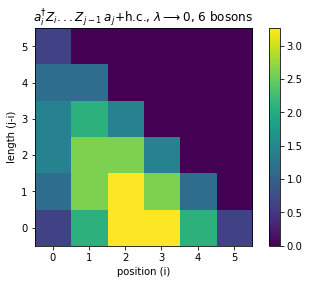

In [414]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(i, " ", np.real(O_n))
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

# from matplotlib import cm
print(resRe.T)
plt.imshow(resRe.T)#,cmap=cm.Reds)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

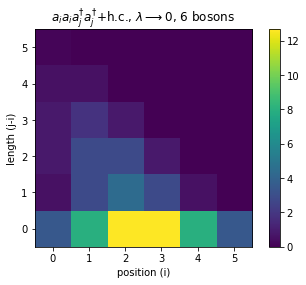

In [404]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

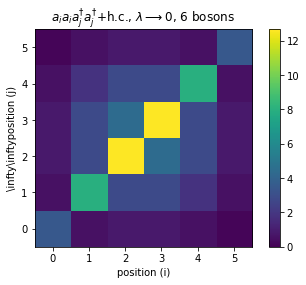

In [415]:
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("\infty\inftyposition (j)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

#### Positive field dominates so |-> lowers the energy the most: ground state is |1-1>

In [424]:
hop = [[0, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[100, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[1.76752246] [0.32706204] [1.44046042]
[2.34397001e-18] [1.37373266e-18] [3.37410027e-18]


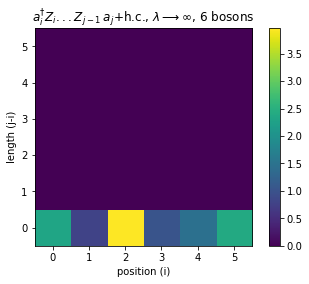

In [425]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe.T)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

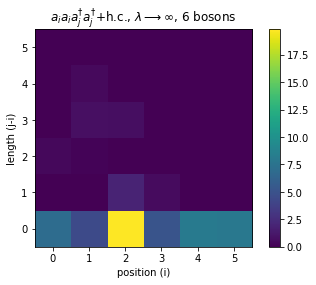

In [426]:
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

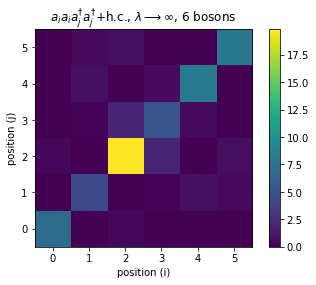

In [427]:
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("position (j)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

### Create |0+2> by hand and check where it is in the basis

In [10]:
##### define initial state #####
psispin = (1 / np.sqrt(2)) * np.array([1, 1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("02")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns, dtype=np.float64)
psiboson[iboson] = 1.0
psi = np.kron(psispin, psiboson)
print(psi)

[0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.        ]


In [11]:
# Check the state which was made
statetest = [[1.0,
              1]]  #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static = [["|n", statetest]]  #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H_check = hamiltonian(static, [], basis=basis, **no_checks)
print(np.dot(psi.conj().T, H_check.dot(psi)))

(1.9999999999999996+0j)
